In [52]:
%run ../common_utils.py

In [5]:
import lightgbm as lgbm
from sklearn.metrics import make_scorer

## Global parameters

In [6]:
random_state = 1

In [7]:
number_of_splits = 5

# Parameter Tuning

## Parameters and defaults:
 * Regularization:
    * reg_lambda (L2) = 0
    * reg_alpha (L1) = 0
    * num_leaves = 31
    * subsample = 1
    * max_depth = -1
* Training
    * n_estimators = 100
    * early_stopping_rounds = None
    * categorical_feature (don't use one hot!) = 'auto'
    * learning_rate = eta = 0.1
* Reproducability
    * random_state = None

# Load Data

In [64]:
def load_data(val_data=False):
    train, test, metadata = load_all_data()
    nonCategorical, categorical = get_cat_and_non_cat_data(metadata)
    categorical.remove('district')
    all_features = list(train.columns)
    all_features.remove('price')
    numerical_features = ['area_total','area_kitchen','area_living','floor','rooms','ceiling',
        'bathrooms_shared','bathrooms_private','balconies','loggias','phones','building_id','constructed','stories']
    categorical_to_numerical(train, ['street','address'])
    categorical_to_numerical(test, ['street','address'])
    if not val_data:
        X_train, y_train, test_labels = pre_process_numerical(features = all_features, numerical_features = numerical_features, train = train, test = test,
                            outliers_value=7, val_data=val_data, val_split=0.2, random_state=42, scaler="std",
                            add_R="True", add_rel_height="True", droptable=[],
                            one_hot_encode=False, cat_features=categorical, drop_old=True)
        y_train_log = np.log(y_train)
        return X_train, y_train, y_train_log, test_labels
    else:
        X_train, y_train, X_test, y_test, test_labels = pre_process_numerical(features = all_features, numerical_features = numerical_features, train = train, test = test,
                            outliers_value=7, val_data=val_data, val_split=0.2, random_state=42, scaler="std",
                            add_R="True", add_rel_height="True", droptable=[],
                            one_hot_encode=False, cat_features=categorical, drop_old=True)
        y_train_log = np.log(y_train)
        return X_train, y_train, y_train_log, X_test, y_test, test_labels


In [65]:
X_train, y_train, y_train_log, test_labels = load_data()

Std


# Different models

In [66]:
lgbm1 = lgbm.LGBMRegressor(
    num_leaves=10,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    num_iterations=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

In [67]:
lgbm2 = lgbm.LGBMRegressor(
    random_state=33,
    early_stopping_rounds = 10,
    num_iterations=10000
)

In [68]:
lgbm3 = lgbm.LGBMRegressor(
    num_leaves=40,
    max_depth=10, 
    random_state=42, 
    silent=True, 
    metric='regression',
    num_threads=4, 
    num_iterations=10000,
    feature_fraction=0.8,
    bagging_fraction=0.9,
    bagging_freq=5,
    learning_rate=0.05,
    early_stopping_round=20
)

# Select features and perform cross validation

In [69]:
selected_features = ['area_total','area_kitchen','floor','bathrooms_private',
            'r','district','constructed','stories','rel_height','parking','building_id']
X_train_selected = X_train[selected_features]

## LGBM1

In [70]:
%%capture --no-display

number_splits = 5

scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_splits,
    model=lgbm1,
    X_train=X_train_selected, 
    y_train=y_train_log,
)

In [71]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.23118292412679553, 0.23263064167534026, 0.20547779947511238, 0.2312861287649293, 0.25151078165405255]
average score:  0.230417655139246
best model:     LGBMRegressor(colsample_bytree=0.95, learning_rate=0.05, max_depth=5,
              metric='mse', n_jobs=4, num_iterations=2000, num_leaves=10,
              random_state=42, subsample=0.9)
best index:     2


In [72]:
# predict_and_store(best_model, test_labels[selected_features], test_labels, path=".\submissions\LGBM3.0.csv", exponential=True)

## LGBM2 

In [73]:
%%capture --no-display

number_splits = 5

scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_splits,
    model=lgbm2,
    X_train=X_train_selected, 
    y_train=y_train_log)

In [74]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.22640759671874694, 0.23259010459041174, 0.21018417726199096, 0.23148867266928222, 0.24413585259687426]
average score:  0.2289612807674612
best model:     LGBMRegressor(early_stopping_rounds=10, num_iterations=10000, random_state=33)
best index:     2


## LGBM3

In [75]:
%%capture --no-display

number_splits = 5

scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_splits,
    model=lgbm3,
    X_train=X_train_selected, 
    y_train=y_train_log)

In [76]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.2292257013193565, 0.22792769163594595, 0.2076961273873549, 0.22706377876549386, 0.2419961271235586]
average score:  0.22678188524634196
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=20,
              feature_fraction=0.8, learning_rate=0.05, max_depth=10,
              metric='regression', num_iterations=10000, num_leaves=40,
              num_threads=4, random_state=42)
best index:     2


# Scikit-learn random grid search with cross validation

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

lgbm4 = lgbm.LGBMRegressor(
    random_state=42, 
    silent=True, 
    metric='regression',
    num_threads=4, 
)



learning_rate=0.05,


distributions = dict(num_iterations = np.logspace(2,5,10).astype(int),
                     num_leaves = np.linspace(10,50,21).astype(int),
                     max_depth = np.linspace(5,19,8).astype(int),
                     feature_fraction = np.arange(0.7,0.999,0.05),
                     bagging_fraction = np.arange(0.7,0.999,0.05),
                     bagging_freq = np.arange(1,11,1),
                     learning_rate = np.geomspace(0.001,0.1,10))

clf = RandomizedSearchCV(lgbm4, distributions, random_state=42, scoring=custom_asymmetric_eval)

groups = X_train["building_id"]

search = clf.fit(  
    X=X_train_selected, 
    y=y_train_log, 
    groups=groups)

search.best_params_

In [78]:
search.best_estimator_

LGBMRegressor(bagging_fraction=0.75, bagging_freq=7,
              feature_fraction=0.9000000000000001,
              learning_rate=0.03593813663804626, max_depth=13,
              metric='regression', num_iterations=10000, num_leaves=44,
              num_threads=4, random_state=42)

In [79]:
lgbm5 = lgbm.LGBMRegressor(
  bagging_fraction=0.75, bagging_freq=7,
  feature_fraction=0.9000000000000001,
  learning_rate=0.03593813663804626, max_depth=13,
  metric='regression', num_iterations=10000, num_leaves=44,
  num_threads=4, random_state=42
)

In [80]:
%%capture --no-display

number_splits = 5

scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_splits,
    model=lgbm5,
    X_train=X_train_selected, 
    y_train=y_train_log)

In [81]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.23014950375934523, 0.23284639473020902, 0.20518920634947269, 0.23264523255916678, 0.24686212028764995]
average score:  0.2295384915371687
best model:     LGBMRegressor(bagging_fraction=0.75, bagging_freq=7,
              feature_fraction=0.9000000000000001,
              learning_rate=0.03593813663804626, max_depth=13,
              metric='regression', num_iterations=10000, num_leaves=44,
              num_threads=4, random_state=42)
best index:     2


In [82]:
lgbm6 = lgbm.LGBMRegressor(
  bagging_fraction=0.75, bagging_freq=7,
  feature_fraction=0.9000000000000001,
  learning_rate=0.03593813663804626, max_depth=13,
  metric='regression', num_iterations=10000, num_leaves=44,
  num_threads=4, random_state=42, early_stopping_rounds=10
)

In [83]:
%%capture --no-display

number_splits = 5

scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_splits,
    model=lgbm6,
    X_train=X_train_selected, 
    y_train=y_train_log)

In [84]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.2299538499967988, 0.23343199481553234, 0.20729615982822808, 0.22900294778472285, 0.24999434796687037]
average score:  0.22993586007843048
best model:     LGBMRegressor(bagging_fraction=0.75, bagging_freq=7, early_stopping_rounds=10,
              feature_fraction=0.9000000000000001,
              learning_rate=0.03593813663804626, max_depth=13,
              metric='regression', num_iterations=10000, num_leaves=44,
              num_threads=4, random_state=42)
best index:     2


In [85]:
%%capture --no-display

lgbm7 = lgbm.LGBMRegressor(
    random_state=42, 
    silent=True, 
    metric='regression',
    num_threads=4, 
)





distributions = dict(num_iterations = np.logspace(2,5,10).astype(int),
                     num_leaves = np.linspace(10,50,21).astype(int),
                     max_depth = np.linspace(5,19,8).astype(int),
                     feature_fraction = np.arange(0.7,0.999,0.05),
                     bagging_fraction = np.arange(0.7,0.999,0.05),
                     bagging_freq = np.arange(1,11,1),
                     learning_rate = np.geomspace(0.001,0.1,10))

scorer = make_scorer(custom_asymmetric_eval, greater_is_better=False)
clf = RandomizedSearchCV(lgbm7, distributions, random_state=42, scoring='neg_root_mean_squared_error')

groups = X_train["building_id"]

search = clf.fit(  
    X=X_train_selected, 
    y=y_train_log, 
    groups=groups,
    eval_metric='neg_root_mean_squared_error')

print(search.best_params_)
print(search.best_estimator_)

In [86]:
%%capture --no-display

number_splits = 5

scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_splits,
    model=search.best_estimator_,
    X_train=X_train_selected, 
    y_train=y_train_log)

In [87]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.22759056074892725, 0.22147621178237537, 0.2045195675868623, 0.2272348246808108, 0.24952146691042046]
average score:  0.22606852634187927
best model:     LGBMRegressor(bagging_fraction=0.9000000000000001, bagging_freq=1,
              feature_fraction=0.7, learning_rate=0.03593813663804626,
              max_depth=15, metric='regression', num_iterations=1000,
              num_leaves=38, num_threads=4, random_state=42)
best index:     2


# Manual tuning

In [88]:
num_iterations = np.logspace(2,5,10).astype(int)
num_leaves = np.linspace(10,50,21).astype(int)
max_depth = np.linspace(5,19,8).astype(int)
feature_fraction = np.arange(0.7,0.999,0.05)
bagging_fraction = np.arange(0.7,0.999,0.05)
bagging_freq = np.arange(1,11,1)
learning_rate = np.geomspace(0.001,0.1,10)

number_splits = 5

In [89]:
lgbm8 = lgbm.LGBMRegressor(
    random_state=random_state, 
    silent=True, 
    metric='regression',
    num_threads=4, 
)

In [90]:
# best_average_score = 1
# for n_it in num_iterations:
#     print("level 0")
#     for n_leaves in num_leaves:
#         print("level 1")
#         for max_d in max_depth:
#             for feat_frac in feature_fraction:
#                 for bag_frac in bagging_fraction:
#                     for bag_freq in bagging_freq:
#                         for l_rate in learning_rate:
#                             model = lgbm.LGBMRegressor(
#                                         num_iterations = n_it,
#                                         num_leaves = n_leaves,
#                                         max_depth = max_d,
#                                         feature_fraction = feat_frac,
#                                         bagging_fraction = bag_frac,
#                                         bagging_freq = bag_freq,
#                                         learning_rate = l_rate,
#                                         random_state=random_state, 
#                                         silent=True, 
#                                         metric='regression',
#                                         num_threads=4, 
#                                     )
                            
                                          
#                             scores, average_score, _, _ = lgbm_groupKFold(
#                                 number_of_splits=number_splits,
#                                 model=model,
#                                 X_train=X_train, 
#                                 y_train=y_train_log,
#                                 eval_metric = 'neg_root_mean_squared_error'
#                             )
                            
#                             if average_score < best_average_score:
#                                 best_average_score = average_score
#                                 best_params = dict(
#                                         num_iterations = n_it,
#                                         num_leaves = n_leaves,
#                                         max_depth = max_d,
#                                         feature_fraction = feat_frac,
#                                         bagging_fraction = bag_frac,
#                                         bagging_freq = bag_freq,
#                                         learning_rate = l_rate,
#                                 )
#                                 print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
#                                 print(average_score)
#                                 print(best_params)

Promising: https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

# Optuna Result

In [91]:
params= {
 'num_iterations': 10000,
 'n_estimators': 152,
 'learning_rate': 0.05,
 'num_leaves': 40,
 'max_depth': 10,
 'min_data_in_leaf': 20,
 'bagging_fraction': 0.9,
 'bagging_freq': 5,
 'feature_fraction': 0.8,
}

In [92]:
model = lgbm.LGBMRegressor(**params, random_state=random_state,early_stopping_round=100,silent=True,metric='regression',num_threads=4)

In [93]:
%%capture --no-display

number_splits = 5

scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_splits,
    model=model,
    X_train=X_train, 
    y_train=y_train_log)

In [94]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.20465011437743388, 0.1977448937517322, 0.16734444016195668, 0.19721009339813358, 0.23082700368348158]
average score:  0.19955530907454758
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.05, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=152,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     2


In [95]:
predict_and_store(best_model, test_labels, test_labels, path=".\submissions\LGBM4.0.csv", exponential=True)

In [96]:
model_no_early_stopping = lgbm.LGBMRegressor(**params, random_state=random_state,silent=True,metric='regression',num_threads=4)

In [97]:
model_no_early_stopping.fit(X_train,y_train_log)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, feature_fraction=0.8,
              learning_rate=0.05, max_depth=10, metric='regression',
              min_data_in_leaf=20, n_estimators=152, num_iterations=10000,
              num_leaves=40, num_threads=4, random_state=1)

In [98]:
predict_and_store(model_no_early_stopping, test_labels, test_labels, path=".\submissions\LGBM4.1.csv", exponential=True)

# Oof vs actual price in training data

In [99]:
oof_train, oof_test, scores = get_oof_lgbm(model, X_train, y_train_log, test_labels, NFOLDS=5, eval_metric='neg_root_mean_squared_error')

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[264]	valid_0's l2: 0.0422055
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsampl

In [100]:
X_train.columns

Index(['apartment_id', 'seller', 'area_total', 'area_kitchen', 'area_living',
       'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared',
       'bathrooms_private', 'windows_court', 'windows_street', 'balconies',
       'loggias', 'condition', 'phones', 'building_id', 'new', 'latitude',
       'longitude', 'district', 'street', 'address', 'constructed', 'material',
       'stories', 'elevator_without', 'elevator_passenger', 'elevator_service',
       'parking', 'garbage_chute', 'heating', 'r', 'theta', 'rel_height'],
      dtype='object')

In [101]:
train, test, metadata = load_all_data()
X_train['prediction'] = oof_train
relevant = X_train[['apartment_id','prediction']]
relevant['price']=np.log(y_train)

<ipython-input-101-8f2e4d4bf5d6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant['price']=np.log(y_train)


In [102]:
relevant

,apartment_id,prediction,price
0,0,15.764034,15.781156
1,12,15.199493,15.213027
2,55,16.006021,16.066828
3,104,15.301301,15.280306
4,106,15.301301,15.281997
...,...,...,...
23280,23228,15.999328,16.341239
23281,23229,15.335171,15.473739
23282,23248,16.487494,16.418200
23283,23250,16.611554,16.754672


In [103]:
relevant_sorted = relevant.sort_values(by=['price'],ignore_index=True)

In [104]:
relevant_sorted['x_axis']=list(relevant_sorted.index)

In [105]:
relevant_sorted

,apartment_id,prediction,price,x_axis
0,13205,14.468298,13.710150,0
1,7572,15.070069,13.815511,1
2,13206,14.938502,13.955273,2
3,20329,15.057846,13.997832,3
4,21102,15.126555,14.151983,4
...,...,...,...,...
23219,13963,18.949484,19.769936,23219
23220,2467,18.896513,19.769936,23220
23221,10279,19.428128,19.776598,23221
23222,3551,18.755040,19.781657,23222


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


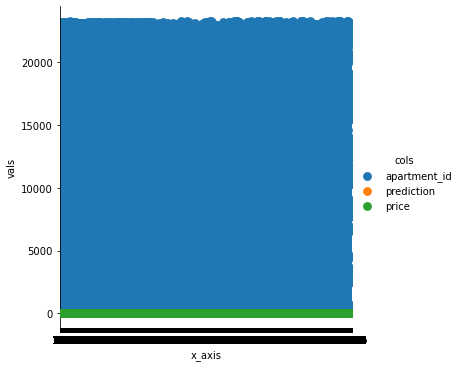

In [106]:
df = relevant_sorted.melt('x_axis', var_name='cols',  value_name='vals')
g = sns.factorplot(x="x_axis", y="vals", hue='cols', data=df)

# New features and data cleaning

In [8]:
params= {
 'num_iterations': 10000,
 'n_estimators': 152,
 'learning_rate': 0.05,
 'num_leaves': 40,
 'max_depth': 10,
 'min_data_in_leaf': 20,
 'bagging_fraction': 0.9,
 'bagging_freq': 5,
 'feature_fraction': 0.8,
}

In [121]:
model = lgbm.LGBMRegressor(
    **params, 
    random_state=random_state,
    early_stopping_round=100,
    silent=True,
    metric='regression',
    num_threads=4)

In [22]:
model_no_cv = lgbm.LGBMRegressor(
    **params, 
    random_state=random_state,
    silent=True,
    metric='regression',
    num_threads=4)

In [8]:
# Define the features (this is all)
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = []

# Load data
train, test, metaData = load_all_data()
# Clean data
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features, log_targets=False, log_area=True, fillNan=True)
# Add new features
train_labels, test_labels, added_features = feature_engineering(train_labels, test_labels, float_numerical_features, int_numerical_features, cat_features)
# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")
# One-hot encoding
train_labels, test_labels = one_hot_encoder(train_labels, test_labels, ["condition", "district", "material", "parking", "heating", "seller"], drop_old=True)
# Drop some features
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

minMax


In [18]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model,
    X_train=train_labels, 
    y_train=np.log(train_targets))

In [20]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.20357889960952982, 0.177624948782267, 0.19300905559648662, 0.17974983167022934, 0.22691051881636098]
average score:  0.19617465089497474
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.05, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=152,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     1


In [23]:
model_no_cv.fit(train_labels,np.log(train_targets))

LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, feature_fraction=0.8,
              learning_rate=0.05, max_depth=10, metric='regression',
              min_data_in_leaf=20, n_estimators=152, num_iterations=10000,
              num_leaves=40, num_threads=4, random_state=1)

In [28]:
predict_and_store(model_no_cv, test_labels, test, path=".\submissions\LGBM5.0.csv", exponential=True)

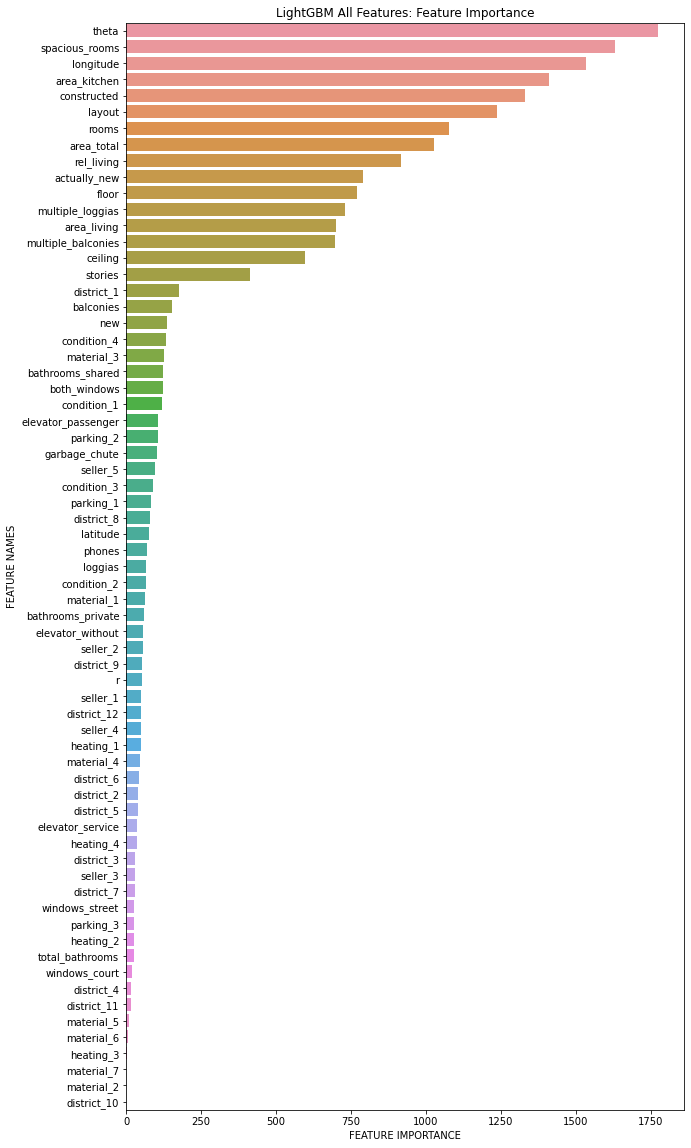

In [45]:
lgbm_importances = model.feature_importances_
plot_feature_importance(lgbm_importances, list(train_labels.drop(['building_id'],axis=1).columns), 'LightGBM All Features: ')

# LGBM on less features

In [122]:
droptable = ['district_10','district_11','district_4','district_7','district_6','district_2','district_5','district_9', 'district_12',
             'material_2','material_7','material_6','material_5','material_4','material_1',
             'heating_3','heating_2','heating_4','heating_1',
             'parking_3',
             'seller_3','seller_4','seller_1','seller_2',
             'windows_court','total_bathrooms', 'windows_street','elevator_service','r','elevator_without','bathrooms_private','loggias','phones']
# Drop some features
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

In [126]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model,
    X_train=train_labels, 
    y_train=np.log(train_targets))

In [127]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.20605667380710743, 0.18131902955465284, 0.1944496808312735, 0.17879311475631657, 0.2246496252480902]
average score:  0.19705362483948813
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.005, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=1520,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     3


In [50]:
model_no_cv.fit(train_labels,np.log(train_targets))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, feature_fraction=0.8,
              learning_rate=0.05, max_depth=10, metric='regression',
              min_data_in_leaf=20, n_estimators=152, num_iterations=10000,
              num_leaves=40, num_threads=4, random_state=1)

In [51]:
predict_and_store(model_no_cv, test_labels, test, path=".\submissions\LGBM5.1.csv", exponential=True)

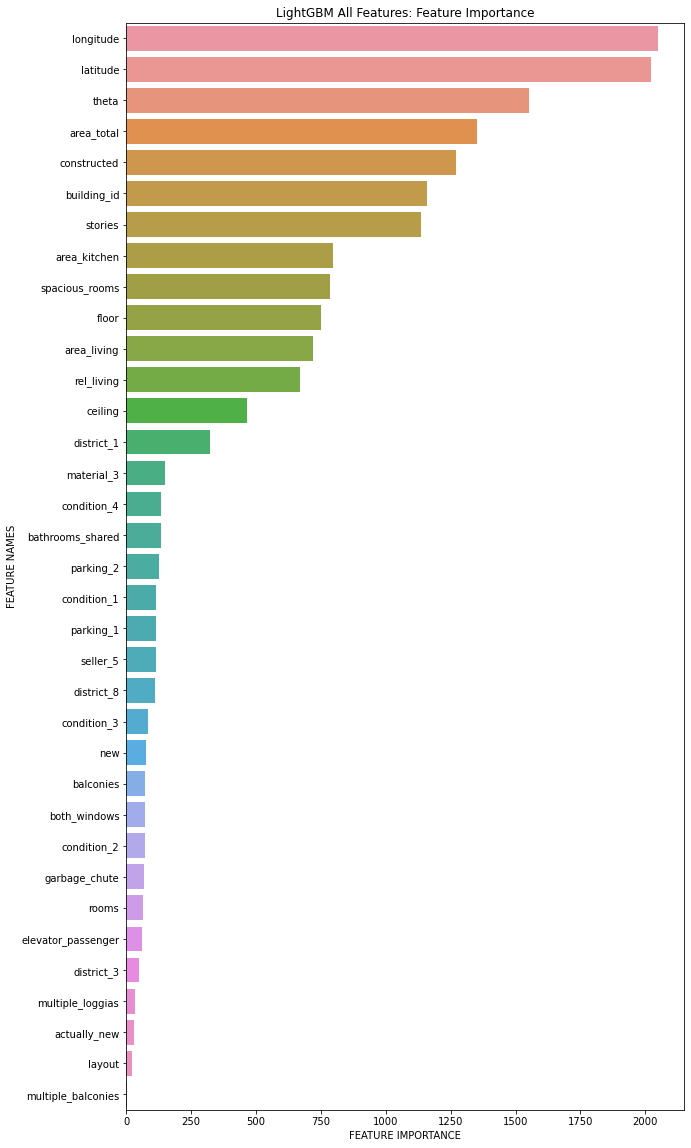

In [59]:
lgbm_importances = model.feature_importances_
plot_feature_importance(lgbm_importances, list(train_labels.columns), 'LightGBM Selected Features: ')

# LGBM Decrease Learning Rate

In [107]:
params= {
 'num_iterations': 10000,
 'n_estimators': 152*5,
 'learning_rate': 0.05/5,
 'num_leaves': 40,
 'max_depth': 10,
 'min_data_in_leaf': 20,
 'bagging_fraction': 0.9,
 'bagging_freq': 5,
 'feature_fraction': 0.8,
}
model = lgbm.LGBMRegressor(
    **params, 
    random_state=random_state,
    early_stopping_round=100,
    silent=True,
    metric='regression',
    num_threads=4)
model_no_cv = lgbm.LGBMRegressor(
    **params, 
    random_state=random_state,
    silent=True,
    metric='regression',
    num_threads=4)

In [133]:
# Define the features (this is all)
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = []

# Load data
train, test, metaData = load_all_data()
# Clean data
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features, log_targets=False, log_area=True, fillNan=True)
# Add new features
train_labels, test_labels, added_features = feature_engineering(train_labels, test_labels, float_numerical_features, int_numerical_features, cat_features)
# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")
# One-hot encoding
train_labels, test_labels = one_hot_encoder(train_labels, test_labels, ["condition", "district", "material", "parking", "heating", "seller"], drop_old=True)
# Drop some features
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

minMax


In [109]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model,
    X_train=train_labels, 
    y_train=np.log(train_targets))

In [110]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.20220429806684384, 0.17891071942742653, 0.190858758038888, 0.17753557430888034, 0.22793414770532708]
average score:  0.19548869950947315
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.01, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=760,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     3


In [120]:
model_no_cv.fit(train_labels,np.log(train_targets))
predict_and_store(model_no_cv, test_labels, test, path=".\submissions\LGBM5.2.csv", exponential=True)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


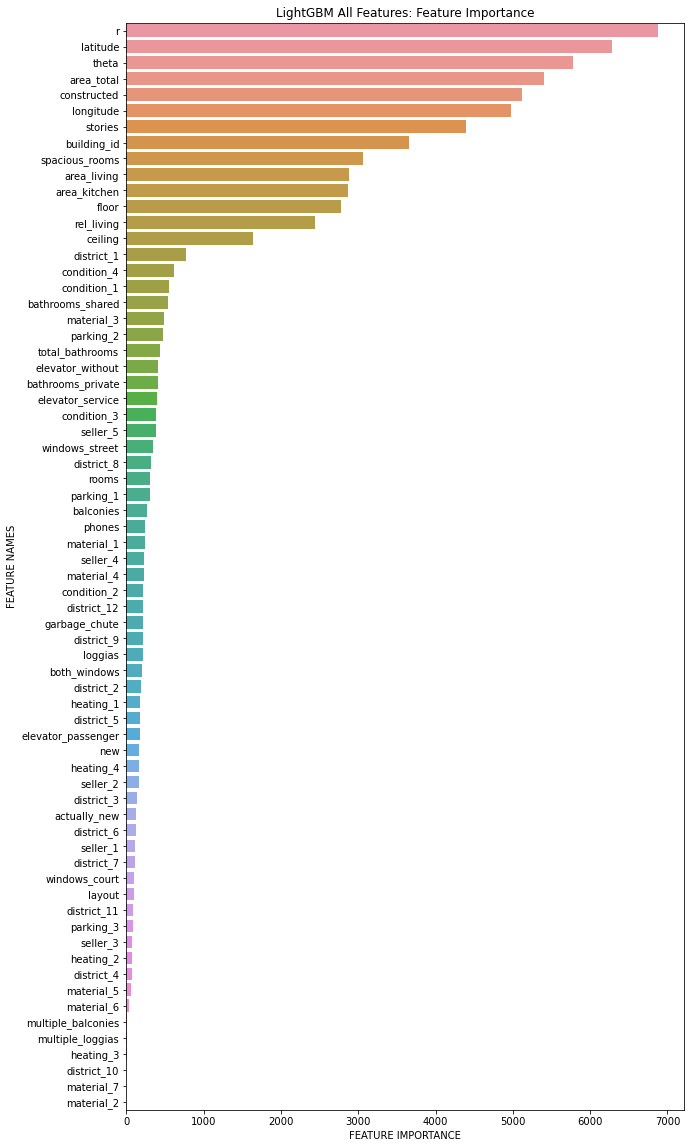

In [113]:
lgbm_importances = model.feature_importances_
plot_feature_importance(lgbm_importances, list(train_labels.columns), 'LightGBM All Features: ')

In [114]:
params= {
 'num_iterations': 10000,
 'n_estimators': 152*10,
 'learning_rate': 0.05/10,
 'num_leaves': 40,
 'max_depth': 10,
 'min_data_in_leaf': 20,
 'bagging_fraction': 0.9,
 'bagging_freq': 5,
 'feature_fraction': 0.8,
}
model = lgbm.LGBMRegressor(
    **params, 
    random_state=random_state,
    early_stopping_round=100,
    silent=True,
    metric='regression',
    num_threads=4)
model_no_cv = lgbm.LGBMRegressor(
    **params, 
    random_state=random_state,
    silent=True,
    metric='regression',
    num_threads=4)

In [116]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model,
    X_train=train_labels, 
    y_train=np.log(train_targets))

In [117]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.20288038090240507, 0.17937356732143844, 0.19128547286617087, 0.1772900347436588, 0.23034859632940918]
average score:  0.19623561043261648
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.005, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=1520,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     3


In [119]:
model_no_cv.fit(train_labels,np.log(train_targets))
predict_and_store(model_no_cv, test_labels, test, path=".\submissions\LGBM5.3.csv", exponential=True)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


# Decreased learning rate on not all features

In [129]:
params= {
 'num_iterations': 10000,
 'n_estimators': 152*5,
 'learning_rate': 0.05/5,
 'num_leaves': 40,
 'max_depth': 10,
 'min_data_in_leaf': 20,
 'bagging_fraction': 0.9,
 'bagging_freq': 5,
 'feature_fraction': 0.8,
}
model = lgbm.LGBMRegressor(
    **params, 
    random_state=random_state,
    early_stopping_round=100,
    silent=True,
    metric='regression',
    num_threads=4)
model_no_cv = lgbm.LGBMRegressor(
    **params, 
    random_state=random_state,
    silent=True,
    metric='regression',
    num_threads=4)

In [145]:
selected_features=[]
for i in range(0,len(lgbm_importances)):
    if lgbm_importances[i] > 100:
        features = (train_labels.columns)
        selected_features += [features[i]]


In [152]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model,
    X_train=train_labels[selected_features], 
    y_train=np.log(train_targets))

In [153]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.20390000289252636, 0.18149527626673134, 0.1908486745650924, 0.1780265666589475, 0.22581404972149582]
average score:  0.19601691402095867
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.01, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=760,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     3


In [156]:
model_no_cv.fit(train_labels[selected_features],np.log(train_targets))
predict_and_store(model_no_cv, test_labels[selected_features], test, path=".\submissions\LGBM5.4.csv", exponential=True)

# Targets: price per square meter

In [24]:
# make sure all data is what we expect
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = []

# Load data
train, test, metaData = load_all_data()
# Clean data
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features, log_targets=False, log_area=True, fillNan=True)
# Add new features
train_labels, test_labels, added_features = feature_engineering(train_labels, test_labels, float_numerical_features, int_numerical_features, cat_features)
# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")
# One-hot encoding
train_labels, test_labels = one_hot_encoder(train_labels, test_labels, ["condition", "district", "material", "parking", "heating", "seller"], drop_old=True)
# Drop some features
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

minMax


In [23]:
price_per_square_meter = train_targets/train['area_total']

In [29]:
params= {
 'num_iterations': 10000,
 'n_estimators': 152*5,
 'learning_rate': 0.05/5,
 'num_leaves': 40,
 'max_depth': 10,
 'min_data_in_leaf': 20,
 'bagging_fraction': 0.9,
 'bagging_freq': 5,
 'feature_fraction': 0.8,
}
model = lgbm.LGBMRegressor(
    **params, 
    random_state=random_state,
    early_stopping_round=100,
    silent=True,
    metric='regression',
    num_threads=4)
model_no_cv = lgbm.LGBMRegressor(
    **params, 
    random_state=random_state,
    silent=True,
    metric='regression',
    num_threads=4)

In [43]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold_not_log_input(
    number_of_splits=number_of_splits,
    model=model,
    X_train=train_labels.drop(['area_total'],axis=1), 
    y_train=price_per_square_meter)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignore

In [44]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.21459887182545095, 0.20198242294697863, 0.2003436258883362, 0.19349876920389042, 0.24668943551444764]
average score:  0.21142262507582074
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.01, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=760,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     3


In [45]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model,
    X_train=train_labels, 
    y_train=np.log(price_per_square_meter))

In [46]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.19201519918971857, 0.17009349466709958, 0.18869479867839964, 0.17557165720744788, 0.21373726961124992]
average score:  0.1880224838707831
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.01, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=760,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     1


In [47]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model,
    X_train=train_labels.drop(['area_total'],axis=1), 
    y_train=np.log(price_per_square_meter))

In [48]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.19329126509741973, 0.1735005279205817, 0.1872286563432924, 0.1758962041260451, 0.21692730845981315]
average score:  0.18936879238943044
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.01, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=760,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     1


In [57]:
model_no_cv.fit(train_labels,price_per_square_meter)
predict_and_store(model_no_cv, test_labels, test, path=".\submissions\LGBM6.3.csv", exponential=False, price_per_sq = True, total_area_df = test['area_total'])

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [61]:
model_no_cv.fit(train_labels.drop(['area_total'],axis=1),price_per_square_meter)
predict_and_store(model_no_cv, test_labels.drop(['area_total'],axis=1), test, path=".\submissions\LGBM6.4.csv", exponential=False, price_per_sq = True, total_area_df = test['area_total'])

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [62]:
model_no_cv.fit(train_labels,np.log(price_per_square_meter))
predict_and_store(model_no_cv, test_labels, test, path=".\submissions\LGBM6.0.csv", exponential=True, price_per_sq = True, total_area_df = test['area_total'])

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [96]:
model_no_cv.fit(train_labels.drop(['area_total'],axis=1),np.log(price_per_square_meter))
predict_and_store(model_no_cv, test_labels.drop(['area_total'],axis=1), test, path=".\submissions\LGBM6.1.csv", exponential=True, price_per_sq = True, total_area_df = test['area_total'])

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


KeyboardInterrupt: 

# Add result of more feature engineering

In [75]:
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute", # Bool
                     "street", "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = []

# Load data
train, test, metaData = load_all_data()
# Clean data
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features, log_targets=False, log_area=True, fillNan=True)
# Add new features
train_labels, test_labels, added_features = feature_engineering(
    train_labels, 
    test_labels,
    add_base_features=True, 
    add_bool_features=True,
    add_weak_features=True,
    add_dist_to_metro=True,
    add_close_to_uni=True,
    add_dist_to_hospital=True,
    add_floor_features=True,
    add_street_info=True,
    )

# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")
# One-hot encoding
train_labels, test_labels = one_hot_encoder(train_labels, test_labels, ["condition", "district", "material", "parking", "heating", "seller"], drop_old=True)
# Drop some features
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

minMax


In [76]:
droptable = ['street','address']
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

In [77]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model,
    X_train=train_labels, 
    y_train=np.log(train_targets))

In [78]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.20778410443267165, 0.1726446816887817, 0.19017859428667133, 0.18094128081752037, 0.23009726946409764]
average score:  0.19632918613794853
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.01, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=760,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     1


In [79]:
model_no_cv.fit(train_labels,np.log(train_targets))
predict_and_store(model_no_cv, test_labels, test, path=".\submissions\LGBM7.0.csv", exponential=True)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


## train target price per square meter

In [80]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model,
    X_train=train_labels.drop(['area_total'],axis=1), 
    y_train=np.log(price_per_square_meter))

In [81]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.1980706886932435, 0.16610643559268282, 0.18555526214662027, 0.17806633874074773, 0.21717947197810658]
average score:  0.18899563943028017
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.01, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=760,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     1


In [92]:
model_no_cv.fit(train_labels.drop(['area_total'],axis=1),np.log(price_per_square_meter))
predict_and_store(model_no_cv, test_labels.drop(['area_total'],axis=1), test, path=".\submissions\LGBM7.1.csv", exponential=True, price_per_sq = True, total_area_df = test['area_total'])

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [ ]:
train_labels.columns

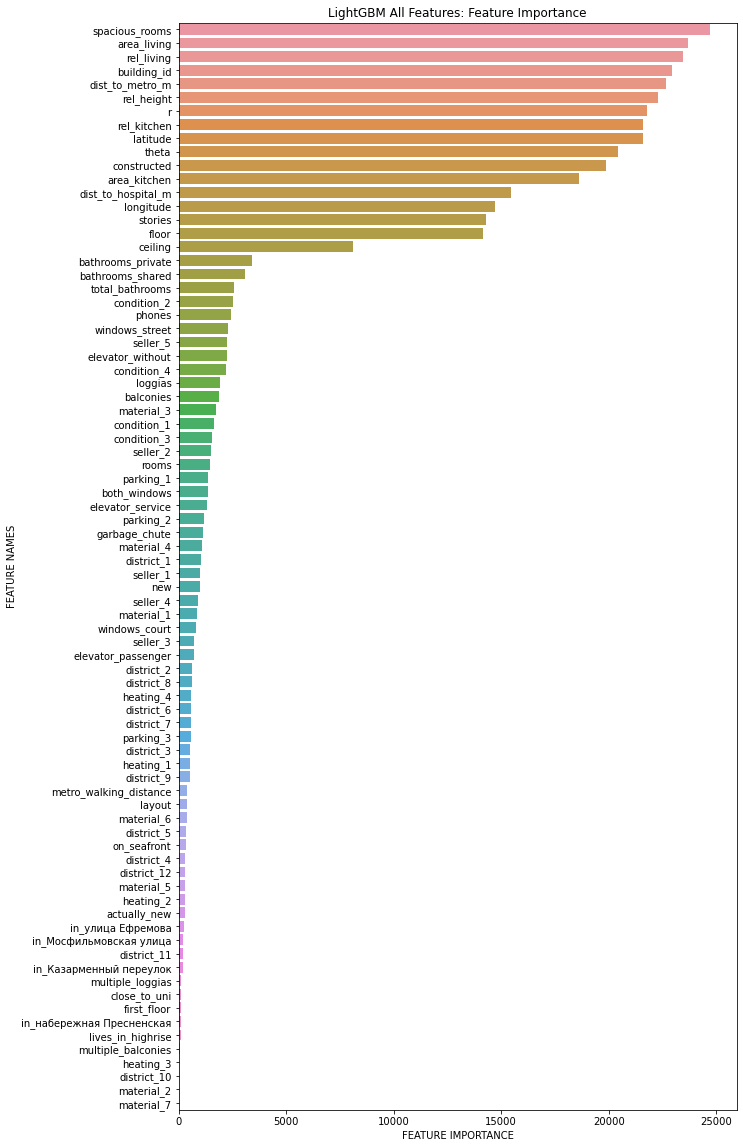

In [93]:
lgbm_importances = model_no_cv.feature_importances_
plot_feature_importance(lgbm_importances, list(train_labels.drop(['area_total'],axis=1).columns), 'LightGBM All Features: ')

In [94]:
selected_features=[]
for i in range(0,len(lgbm_importances)):
    if lgbm_importances[i] > 100:
        features = (train_labels.columns)
        selected_features += [features[i]]


In [99]:
if 'building_id' not in selected_features:
    selected_features_building_id = selected_features + ['building_id']
else:
    selected_features_building_id = selected_features

In [112]:
train_labels_selected = train_labels[selected_features_building_id]
test_labels_selected = test_labels[selected_features_building_id]

In [103]:
%%capture --no-display
scores, average_score, best_model, best_index = lgbm_groupKFold(
    number_of_splits=number_of_splits,
    model=model,
    X_train=train_labels_selected.drop(['area_total'],axis=1), 
    y_train=np.log(price_per_square_meter))

In [104]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.19409646824943821, 0.16751205935126726, 0.1884044522300174, 0.17605024271549852, 0.22049344263989726]
average score:  0.18931133303722375
best model:     LGBMRegressor(bagging_fraction=0.9, bagging_freq=5, early_stopping_round=100,
              feature_fraction=0.8, learning_rate=0.01, max_depth=10,
              metric='regression', min_data_in_leaf=20, n_estimators=760,
              num_iterations=10000, num_leaves=40, num_threads=4,
              random_state=1)
best index:     1


In [113]:
model_no_cv.fit(train_labels_selected.drop(['area_total'],axis=1),np.log(price_per_square_meter))
predict_and_store(model_no_cv, test_labels_selected.drop(['area_total'],axis=1), test, path=".\submissions\LGBM7.2.csv", exponential=True, price_per_sq = True, total_area_df = test['area_total'])

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
